In [1]:
1*2

2

In [2]:
import importlib
def rl():
    importlib.reload(Di)

In [3]:
import GPUtil
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
|  1 |  0% |  0% |
|  2 |  0% |  0% |
|  3 |  0% |  0% |
|  4 |  0% |  0% |
|  5 |  0% |  0% |
|  6 |  0% |  0% |
|  7 |  0% |  0% |


In [4]:
import dask.dataframe as dd
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [5]:
import torch
import gpytorch

import pyarrow as pa
import pyarrow.parquet as pq

from scipy.stats import pearsonr
from scipy.special import binom as binom
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split

import Di

In [6]:
geno_file_list = []
for path, currentDirectory, files in os.walk("96ghpptzvf-4/SData2/"):
    for file in files:
        if file.endswith("geno.txt"):
            geno_file_list.append(file)

geno_file_list = list(set(geno_file_list))

env_list = [file.split('_')[0] for file in geno_file_list]

env_list = sorted(env_list)

In [7]:
env = env_list[5]
print(env)

NaCl


In [8]:
df = pd.read_csv("96ghpptzvf-4/SData2/"+ env + "_geno.txt", sep='\t', nrows=5, engine='python')

In [9]:
ids = list(df.columns[3:])

In [10]:
env + '_matsui_geno_t.pt'

'NaCl_matsui_geno_t.pt'

In [11]:
geno_t = torch.load(env + '_matsui_geno_t.pt')

In [12]:
geno_t = torch.transpose(geno_t, 0, 1)
N, L = geno_t.shape

In [13]:
# ## Use very small subset of loci

# geno_t = torch.transpose(geno_t, 0, 1)

# geno_t = geno_t[:,::2]

# N, L = geno_t.shape

In [14]:
pheno = pd.read_csv("96ghpptzvf-4/SData6/" + env + "_pheno.txt", sep='\t', engine="python")

In [15]:
pheno = pheno.set_index('geno')

In [16]:
pheno = pheno.loc[ids]

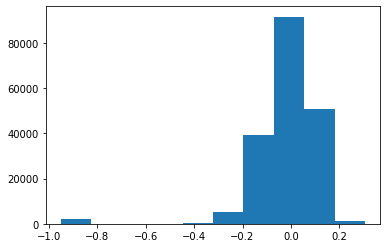

In [17]:
plt.hist(pheno.pheno)
plt.show()

### Set up

In [18]:
n_devices = torch.cuda.device_count()
print('Planning to run on {} GPUs.'.format(n_devices))

Planning to run on 8 GPUs.


In [19]:
output_device = torch.device('cuda:0')

### Data

In [20]:
inds_sub = np.where(np.array(pheno.pheno < -0.6) == False)[0]

In [21]:
np.random.seed(100)

In [22]:
sub = np.random.choice(inds_sub, 40000)

sub_t = np.random.choice(list(set(inds_sub).difference(sub)), 100)

In [23]:
train_x = geno_t[sub]
train_y = torch.tensor(np.array(pheno.pheno[sub]), dtype=torch.float32)

test_x = geno_t[sub_t]
test_y = torch.tensor(np.array(pheno.pheno[sub_t]), dtype=torch.float32)

In [24]:
train_x, train_y = train_x.contiguous(), train_y.contiguous()
test_x, test_y = test_x.contiguous(), test_y.contiguous()

train_x, train_y = train_x.to(output_device), train_y.to(output_device)
test_x, test_y = test_x.to(output_device), test_y.to(output_device)

### Define functions

In [25]:
def d(geno1, geno2):
    """build distance tensor between two sets of genotypes
    geno1, geno2: n x L, m x L torch tensors

    """
    geno1_h0 = 1.*(geno1 == 0.)
    geno1_h1 = 1.*(geno1 == 2.)
    geno2_h0 = 1.*(geno2 == 0.)
    geno2_h1 = 1.*(geno2 == 2.)
    S1 = torch.matmul(geno1%2., torch.transpose(geno2%2., 0, 1))
    S2 = (torch.matmul(geno1_h0, torch.transpose(geno2_h0, 0, 1)) 
        + torch.matmul(geno1_h1, torch.transpose(geno2_h1, 0, 1)))
    D2 = (torch.matmul(geno1_h0, torch.transpose(geno2_h1, 0, 1)) 
        + torch.matmul(geno1_h1, torch.transpose(geno2_h0, 0, 1)))
    D1 = L - S1 - S2 - D2

    return torch.stack((S1, S2, D1, D2))


In [26]:
# def d(geno1, geno2):
#     """build distance tensor between two sets of genotypes
#     geno1, geno2: n x L, m x L torch tensors

#     """
# #     geno1_h0 = 1.*(geno1 == 0.)
# #     geno1_h1 = 1.*(geno1 == 2.)
# #     geno2_h0 = 1.*(geno2 == 0.)
# #     geno2_h1 = 1.*(geno2 == 2.)
#     S1 = torch.matmul(geno1%2., torch.transpose(geno2%2., 0, 1))
#     #   S2 = (torch.matmul(geno1_h0, torch.transpose(geno2_h0, 0, 1)) 
#     #         + torch.matmul(geno1_h1, torch.transpose(geno2_h1, 0, 1)))
#     #   D2 = (torch.matmul(geno1_h0, torch.transpose(geno2_h1, 0, 1)) 
#     #         + torch.matmul(geno1_h1, torch.transpose(geno2_h0, 0, 1)))
#     S2 = S1
#     D2 = S1
#     D1 = L - S1 - S2 - D2

#     return torch.stack((S1, S2, D1, D2))


In [27]:
def k(log_lda, log_eta, dvec):
    """
    log_lda, log_eta -- torch tensors
    dvec -- 4 x n x m torch tensor
    """
    lda = torch.exp(log_lda)
    eta = torch.exp(log_eta)
    return (((1 + lda + eta)**(dvec[1] - L/2))
          *((1 - lda + eta)**dvec[3])
          *((1 + eta)**(dvec[0] - L/2)) 
          * (1-eta)**dvec[2])


In [28]:
from gpytorch.constraints import Positive
from gpytorch.constraints import LessThan


class DiKernel(gpytorch.kernels.Kernel):
  """Diploid kernel"""

  is_stationary = True

  # We will register the parameter when initializing the kernel
  def __init__(self, 
                lda_prior=None, lda_constraint=None, 
                eta_prior=None, eta_constraint=None,
                **kwargs):
      super().__init__(**kwargs)

      # register the raw parameter
      self.register_parameter(
          name='raw_lda', 
          parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
      )

      self.register_parameter(
          name='raw_eta', 
          parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
      )

      # set the parameter constraint to be positive, when nothing is specified
      if lda_constraint is None:
          lda_constraint = LessThan(upper_bound=0.)

      if eta_constraint is None:
          eta_constraint = LessThan(upper_bound=0.)

      # register the constraint
      self.register_constraint("raw_lda", lda_constraint)
      self.register_constraint("raw_eta", eta_constraint)

      
  # now set up the 'actual' paramter
  @property
  def lda(self):
      # when accessing the parameter, apply the constraint transform
      return self.raw_lda_constraint.transform(self.raw_lda)

  @property
  def eta(self):
      # when accessing the parameter, apply the constraint transform
      return self.raw_eta_constraint.transform(self.raw_eta)

  @lda.setter
  def lda(self, value):
      return self._set_lda(value)

  @eta.setter
  def eta(self, value):
      return self._set_eta(value)

  def forward(self, x1, x2, diag=False, **params):
      diff = d(x1, x2)
      K = k(self.lda, self.eta, diff)
      if diag:
        K = K[0]
      return K
      

    
class DiGPModel(gpytorch.models.ExactGP):

  def __init__(self, train_x, train_y, likelihood):
    super().__init__(train_x, train_y, likelihood)
    self.mean_module = gpytorch.means.ConstantMean()
    self.covar_module = gpytorch.kernels.MultiDeviceKernel(
            DiKernel(), device_ids=range(n_devices),
            output_device=output_device
        )

  def forward(self, x):
    mean_x = self.mean_module(x)
    covar_x = self.covar_module(x)
    return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)    

In [29]:
class LinKernel(gpytorch.kernels.Kernel):
  """Additive kernel"""

  is_stationary = True

  # We will register the parameter when initializing the kernel
  def __init__(self, 
                **kwargs):
      super().__init__(**kwargs)

  def forward(self, x1, x2, diag=False, **params):
    K = torch.matmul(x1, x2.T)
    if diag:
        K = K[0]
    return K


class LinGPModel(gpytorch.models.ExactGP):

  def __init__(self, train_x, train_y, likelihood):
    super().__init__(train_x, train_y, likelihood)
    self.mean_module = gpytorch.means.ConstantMean()
    self.covar_module = gpytorch.kernels.MultiDeviceKernel(
            LinKernel(), device_ids=range(n_devices),
            output_device=output_device
        )

  def forward(self, x):
    mean_x = self.mean_module(x)
    covar_x = self.covar_module(x)
    return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)    

In [30]:
class DiGPModel2(gpytorch.models.ExactGP):

  def __init__(self, train_x, train_y, likelihood):
    super().__init__(train_x, train_y, likelihood)
    self.mean_module = gpytorch.means.ConstantMean()
    base_covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    self.covar_module = gpytorch.kernels.MultiDeviceKernel(
            base_covar_module, device_ids=range(n_devices),
            output_device=output_device
        )

  def forward(self, x):
    mean_x = self.mean_module(x)
    covar_x = self.covar_module(x)
    return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)    

### Test linear kernel partitioning

In [34]:
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(output_device)
model = LinGPModel(train_x, train_y, likelihood)
model = model.to(output_device).double()

In [35]:
optimizer = torch.optim.AdamW(model.parameters(), .02)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [36]:
test_x = test_x.cuda()
model.eval()
likelihood.eval()

with gpytorch.beta_features.checkpoint_kernel(0):
    # Make predictions on a small number of test points to get the test time caches computed
    f_preds = model(test_x)


### Test DI kernel partitioning

In [31]:
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(output_device)
model = DiGPModel(train_x, train_y, likelihood)
model.covar_module.module.raw_lda = torch.nn.Parameter(torch.tensor(-8.))
model.covar_module.module.raw_eta = torch.nn.Parameter(torch.tensor(-12.))
model = model.to(output_device).double()

In [32]:
optimizer = torch.optim.AdamW(model.parameters(), .02)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [33]:
# model.train()
# optimizer.zero_grad()

# with gpytorch.beta_features.checkpoint_kernel(0):

#     output = model(train_x)
#     loss = -mll(output, train_y)
#     loss.backward()

In [34]:
test_x = test_x.cuda()
model.eval()
likelihood.eval()

with gpytorch.beta_features.checkpoint_kernel(0):
    # Make predictions on a small number of test points to get the test time caches computed
    f_preds = model(test_x)


In [35]:
import GPUtil
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% | 85% |
|  1 |  0% | 63% |
|  2 |  0% | 63% |
|  3 |  0% | 63% |
|  4 |  0% | 63% |
|  5 |  0% | 63% |
|  6 |  0% | 63% |
|  7 |  0% | 63% |


In [36]:
checkpoint_size = 10000
preconditioner_size = 100

In [37]:
# with gpytorch.beta_features.checkpoint_kernel(checkpoint_size), \
#      gpytorch.settings.max_preconditioner_size(preconditioner_size):
#     output = model(train_x)
#     loss = -mll(output, train_y)
    


In [38]:
f_mean = f_preds.mean.cpu().detach().numpy()
y_test = test_y.detach().cpu().numpy()

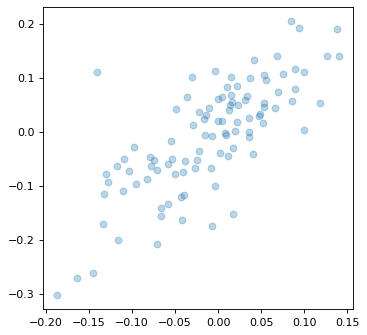

r2 = 0.570276
R2 = 0.566156
mse = 0.004485


In [39]:
# epistatic
figure(figsize=(5, 5), dpi=80)
plt.plot(f_mean, y_test, 'o', alpha=.3)
plt.show()
print('r2 = %f'%pearsonr(f_mean, y_test)[0]**2)
print('R2 = %f'%r2(y_test, f_mean))
print('mse = %f'%mse(f_mean, y_test))

### Test using gaussian kernel

In [74]:
class DiGPModel2(gpytorch.models.ExactGP):

  def __init__(self, train_x, train_y, likelihood):
    super().__init__(train_x, train_y, likelihood)
    self.mean_module = gpytorch.means.ConstantMean()
    base_covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    self.covar_module = gpytorch.kernels.MultiDeviceKernel(
            base_covar_module, device_ids=range(n_devices),
            output_device=output_device
        )

  def forward(self, x):
    mean_x = self.mean_module(x)
    covar_x = self.covar_module(x)
    return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)    

In [75]:
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(output_device)
model = DiGPModel2(train_x, train_y, likelihood)
model = model.to(output_device).double()
optimizer = torch.optim.AdamW(model.parameters(), .02)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


In [77]:
test_x = test_x.cuda()
model.eval()
likelihood.eval()

with gpytorch.beta_features.checkpoint_kernel(1000):
    # Make predictions on a small number of test points to get the test time caches computed
    f_preds = model(test_x)


In [36]:
f_mean = f_preds.mean.cpu().detach().numpy()
y_test = test_y.detach().cpu().numpy()

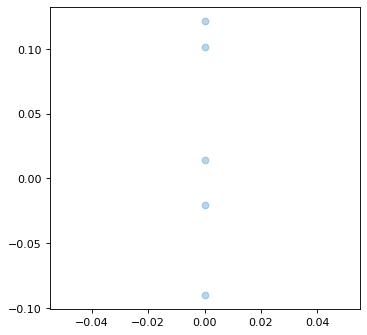

r2 = nan
R2 = -0.103277
mse = 0.006766


/apps/tensorflow/2.4.1.cuda11/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [37]:
# epistatic
figure(figsize=(5, 5), dpi=80)
plt.plot(f_mean, y_test, 'o', alpha=.3)
plt.show()
print('r2 = %f'%pearsonr(f_mean, y_test)[0]**2)
print('R2 = %f'%r2(y_test, f_mean))
print('mse = %f'%mse(f_mean, y_test))

In [38]:
optimizer = torch.optim.AdamW(model.parameters(), .02)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [39]:
model.train()
optimizer.zero_grad()

with gpytorch.beta_features.checkpoint_kernel(100):

    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()

/home/juannanzhou/.local/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /pytorch/aten/src/ATen/native/Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)
